#Clustering Spotify User with K-Prototypes

##Import Library

In [1]:
!pip install kmodes
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [2]:
df = pd.read_csv('/content/spotify_churn_dataset.csv')
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


Rows: Each row represents a unique Spotify user.

Columns (Features):

user_id → Unique identifier for each user

gender → User gender (Male/Female/Other)

age → User age

country → User location

subscription_type → Type of Spotify subscription (Free, Premium, Family, Student)

listening_time → Minutes spent listening per day

songs_played_per_day → Number of songs played daily

skip_rate → Percentage of songs skipped

device_type → Device used (Mobile, Desktop, Web)

ads_listened_per_week → Number of ads heard per week

offline_listening → Offline mode usage

is_churned → Target variable (0 = Active, 1 = Churned)

In [3]:
# cek struktur data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


Dataset spotify churn terdiri dari 8000 baris dan 12 kolom berisi data user spotify. tidak ada tipe data yang aneh dan tidak ada missing value.

##Data Cleaning

### 1. Duplicate Handling

In [4]:
len(df.drop_duplicates()) / len(df)
# jika output dari code di cell ini tidak bernilai 1 maka terdapat duplikat

1.0

Tidak ada data duplikat pada dataset

### 2. Missing Value Handling

In [5]:
df.isna().sum()

,0
user_id,0
gender,0
age,0
country,0
subscription_type,0
listening_time,0
songs_played_per_day,0
skip_rate,0
device_type,0
ads_listened_per_week,0


In [6]:
df.isnull().sum()

,0
user_id,0
gender,0
age,0
country,0
subscription_type,0
listening_time,0
songs_played_per_day,0
skip_rate,0
device_type,0
ads_listened_per_week,0


Tidak ada Missing value pada dataset spotify

### 3. Outlier Handling

In [7]:
import scipy.stats as stats

def check_plot(df, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

    # Deteksi outlier dengan IQR
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[variable] < lower_bound) | (df[variable] > upper_bound)][variable]

    print(f"Jumlah outlier pada '{variable}': {outliers.count()}")
    print(f"Range data tanpa outlier: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Removed the conditional outlier removal block as 'remove_outliers' was not defined
    # if remove_outliers:
    #     df_clean = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)].copy()
    #     print(f"Data setelah outlier dihapus: {df_clean.shape[0]} baris (dari {df.shape[0]} baris awal)")
    #     return df_clean

Checking plot for: age


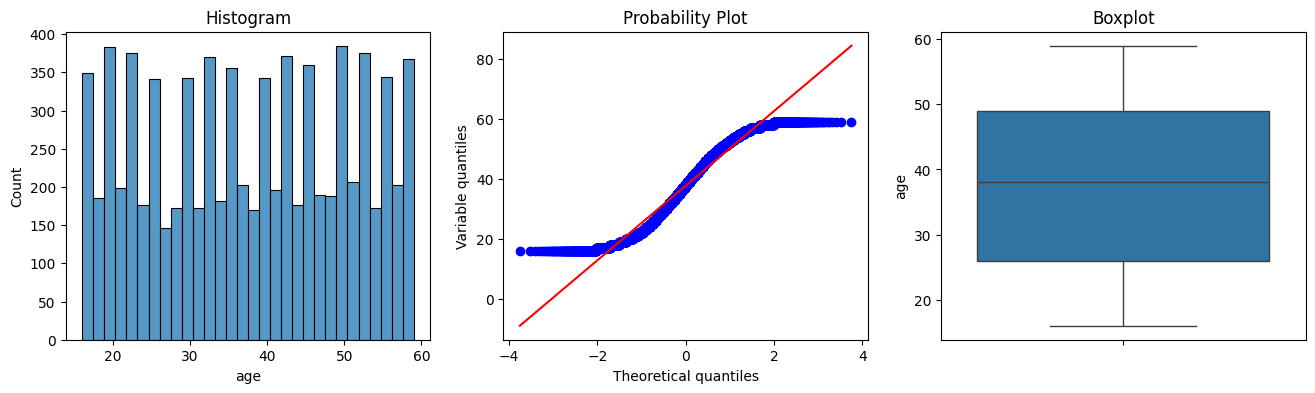

Jumlah outlier pada 'age': 0
Range data tanpa outlier: [-8.50, 83.50]
Checking plot for: listening_time


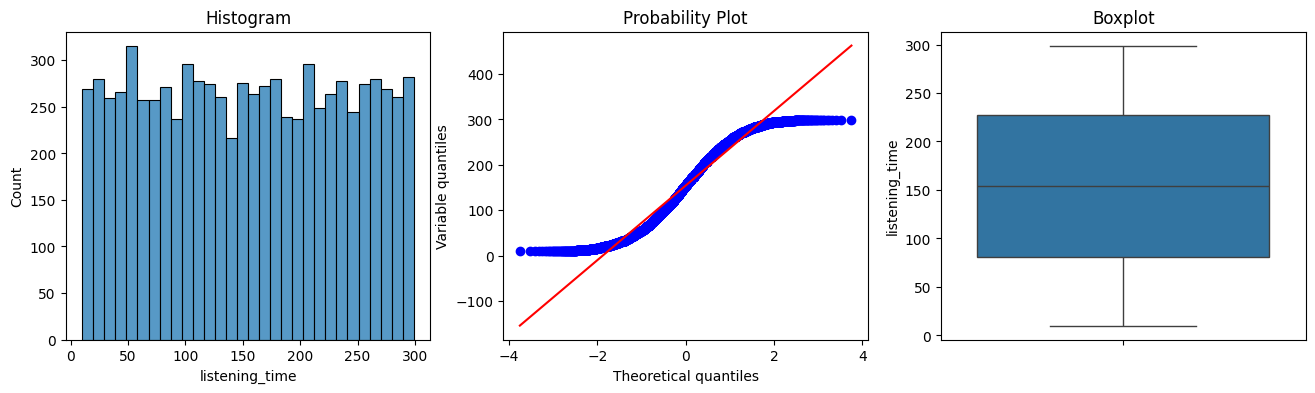

Jumlah outlier pada 'listening_time': 0
Range data tanpa outlier: [-138.00, 446.00]
Checking plot for: songs_played_per_day


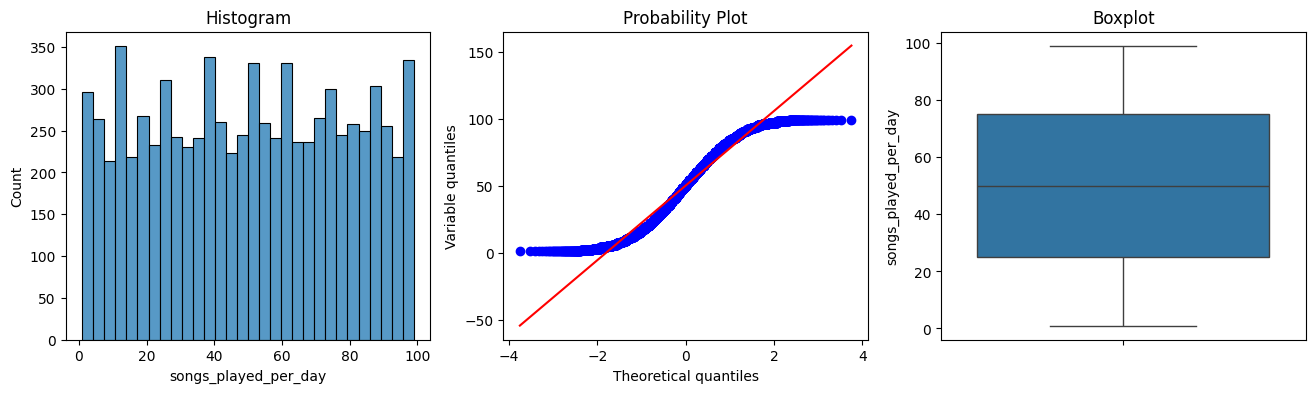

Jumlah outlier pada 'songs_played_per_day': 0
Range data tanpa outlier: [-50.00, 150.00]
Checking plot for: skip_rate


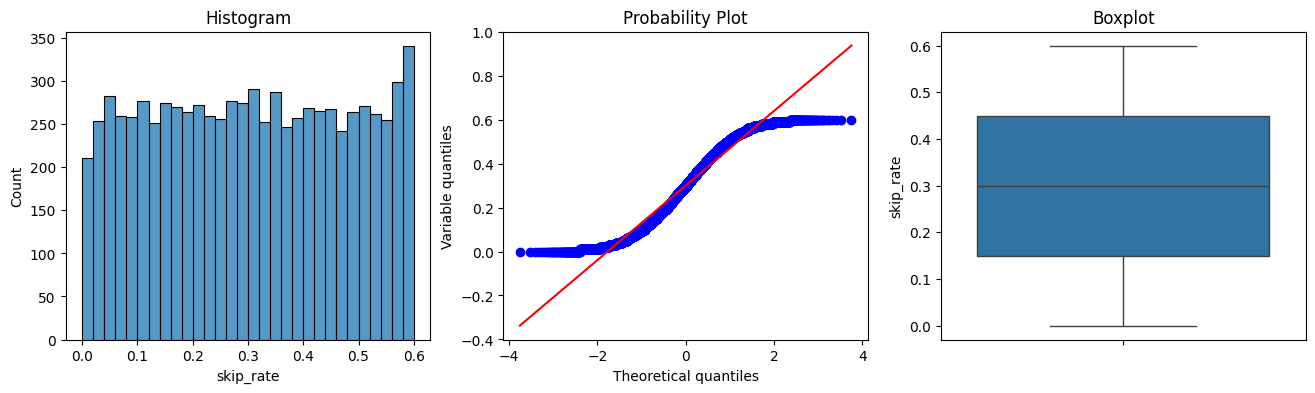

Jumlah outlier pada 'skip_rate': 0
Range data tanpa outlier: [-0.30, 0.90]
Checking plot for: ads_listened_per_week


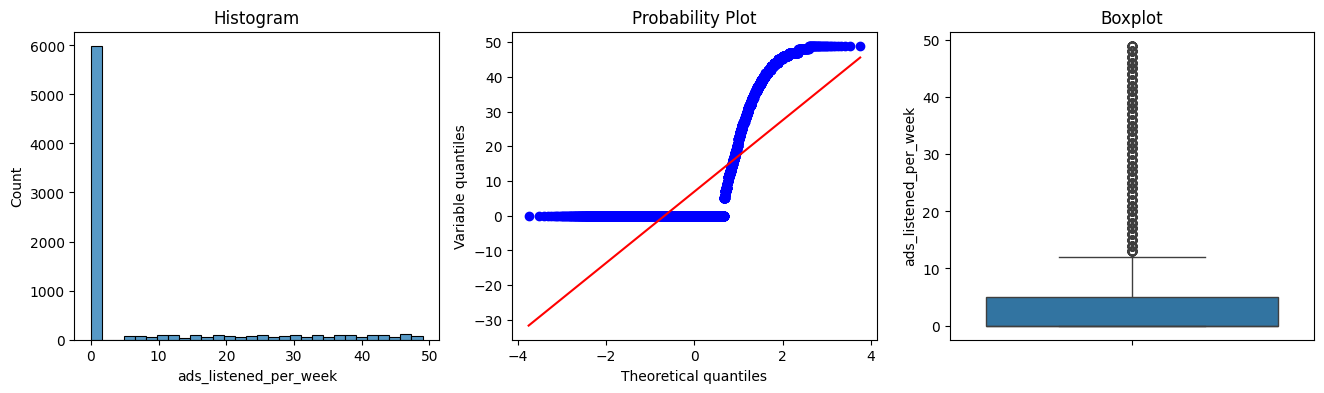

Jumlah outlier pada 'ads_listened_per_week': 1683
Range data tanpa outlier: [-7.50, 12.50]
Checking plot for: offline_listening


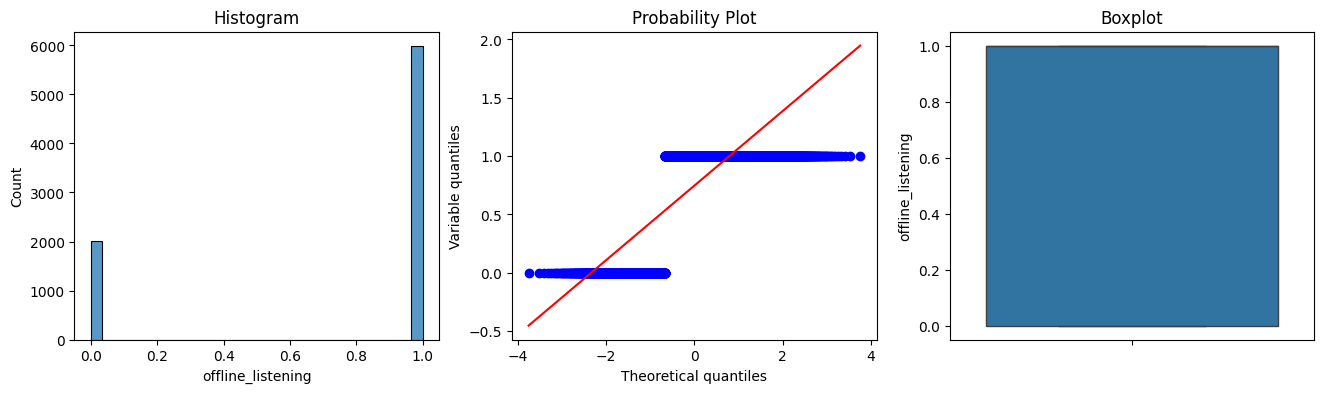

Jumlah outlier pada 'offline_listening': 0
Range data tanpa outlier: [-1.50, 2.50]
Checking plot for: is_churned


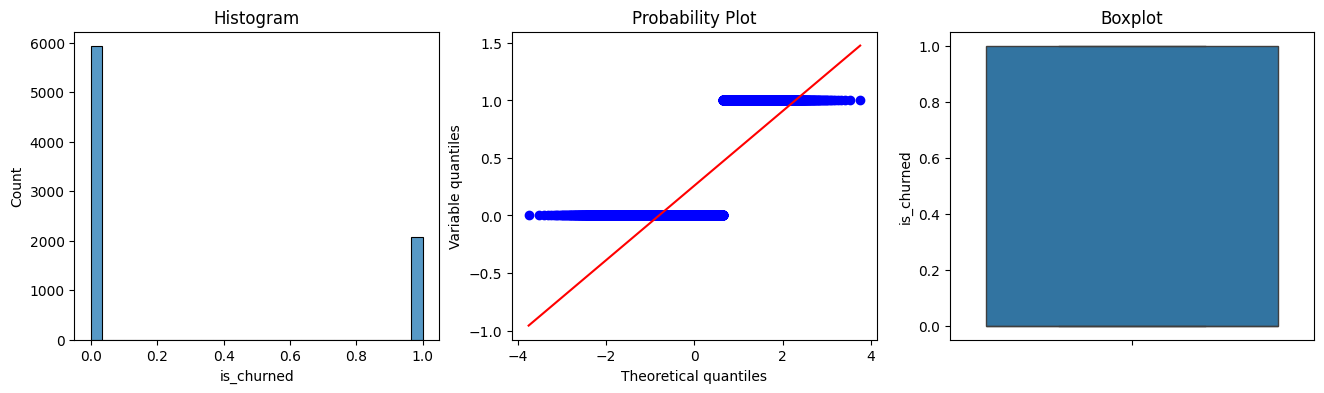

Jumlah outlier pada 'is_churned': 0
Range data tanpa outlier: [-1.50, 2.50]


In [8]:
variables_to_plot = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week', 'offline_listening', 'is_churned']

# To just check the plots for each variable:
for var in variables_to_plot:
    print(f"Checking plot for: {var}")
    check_plot(df, var) # Call the function for each variable

Terdapat 1683 outlier pada kolom ads_listened_per_week. outlier ini akan dihandle dengan log transformation.

In [9]:
df['ads_listened_log'] = np.log1p(df['ads_listened_per_week'])

print("Transformasi berhasil.")

Transformasi berhasil.


Recheck plot setelah dilog transformation

Checking plot for: age


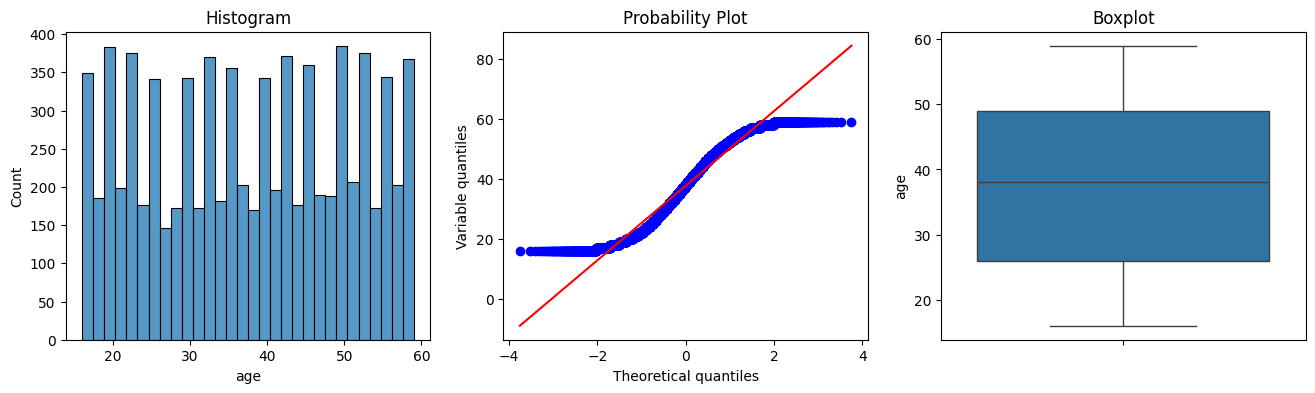

Jumlah outlier pada 'age': 0
Range data tanpa outlier: [-8.50, 83.50]
Checking plot for: listening_time


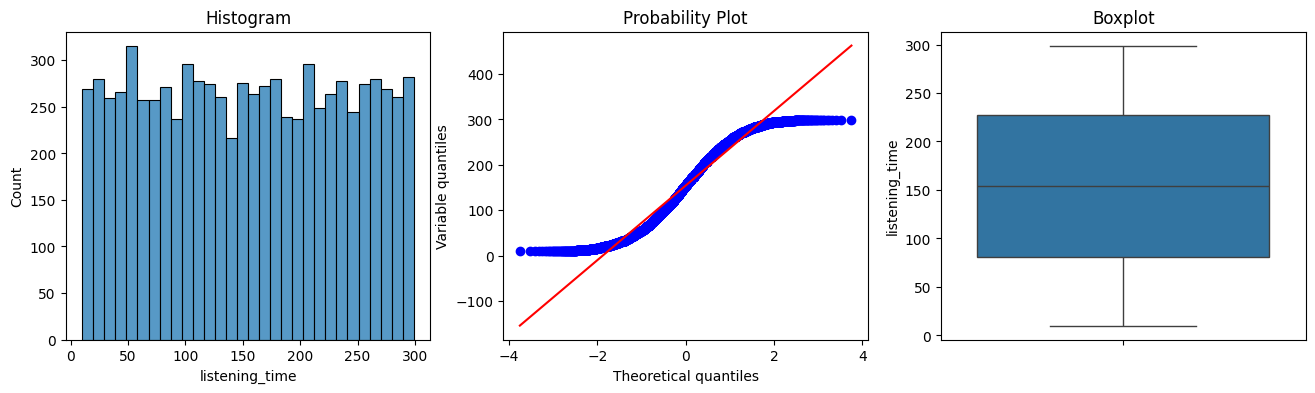

Jumlah outlier pada 'listening_time': 0
Range data tanpa outlier: [-138.00, 446.00]
Checking plot for: songs_played_per_day


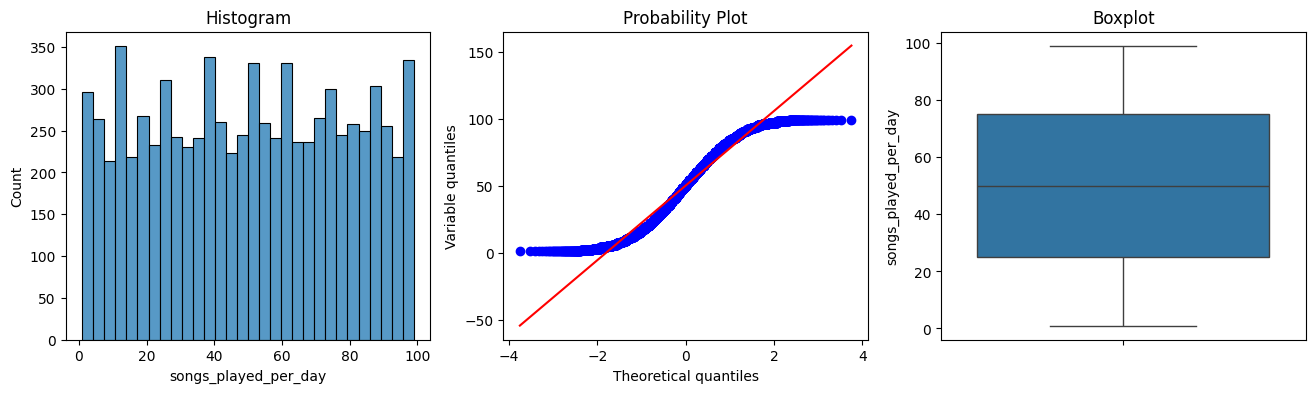

Jumlah outlier pada 'songs_played_per_day': 0
Range data tanpa outlier: [-50.00, 150.00]
Checking plot for: skip_rate


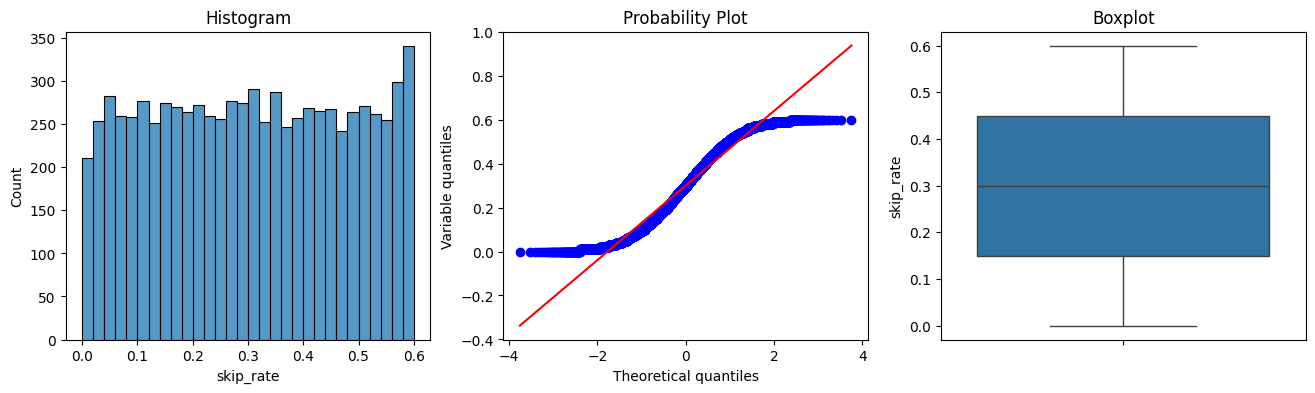

Jumlah outlier pada 'skip_rate': 0
Range data tanpa outlier: [-0.30, 0.90]
Checking plot for: ads_listened_log


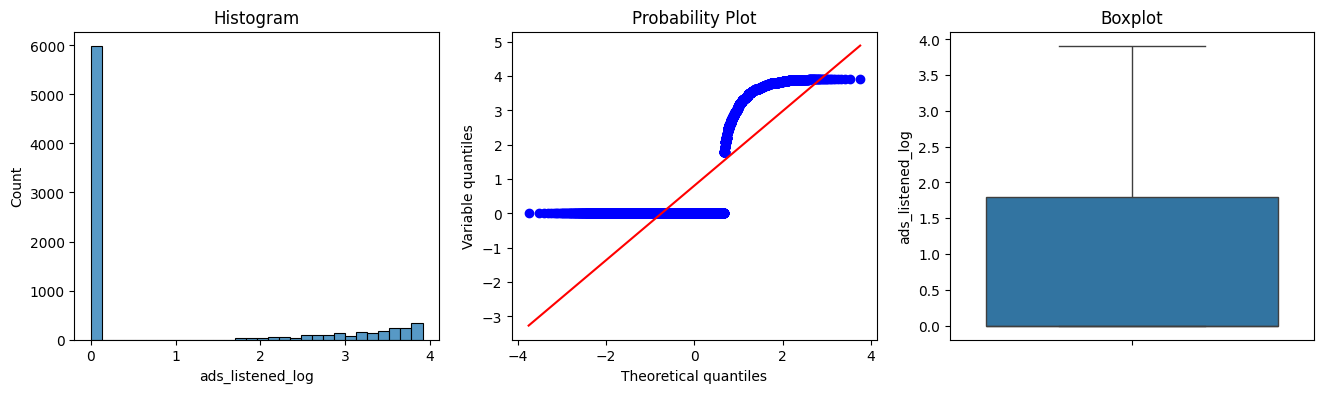

Jumlah outlier pada 'ads_listened_log': 0
Range data tanpa outlier: [-2.69, 4.48]
Checking plot for: offline_listening


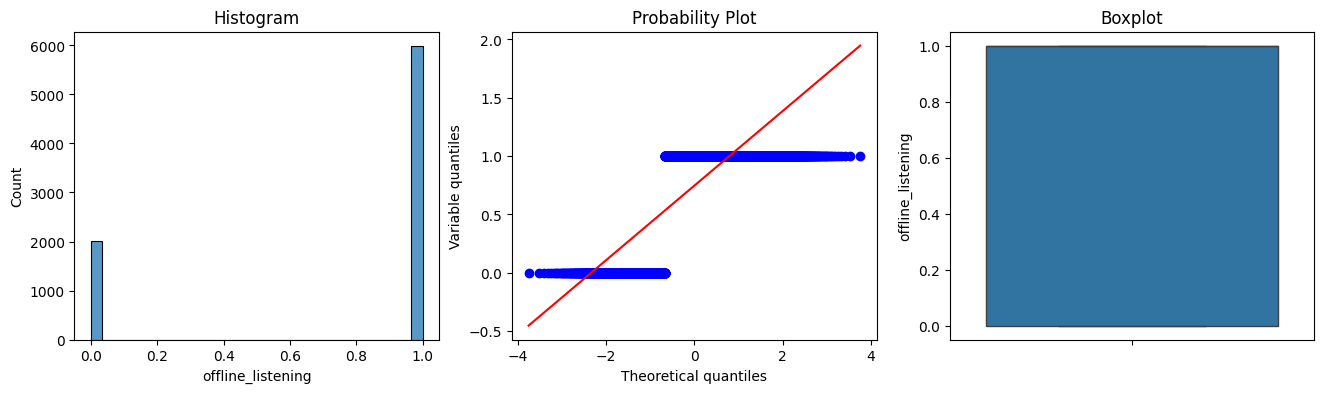

Jumlah outlier pada 'offline_listening': 0
Range data tanpa outlier: [-1.50, 2.50]
Checking plot for: is_churned


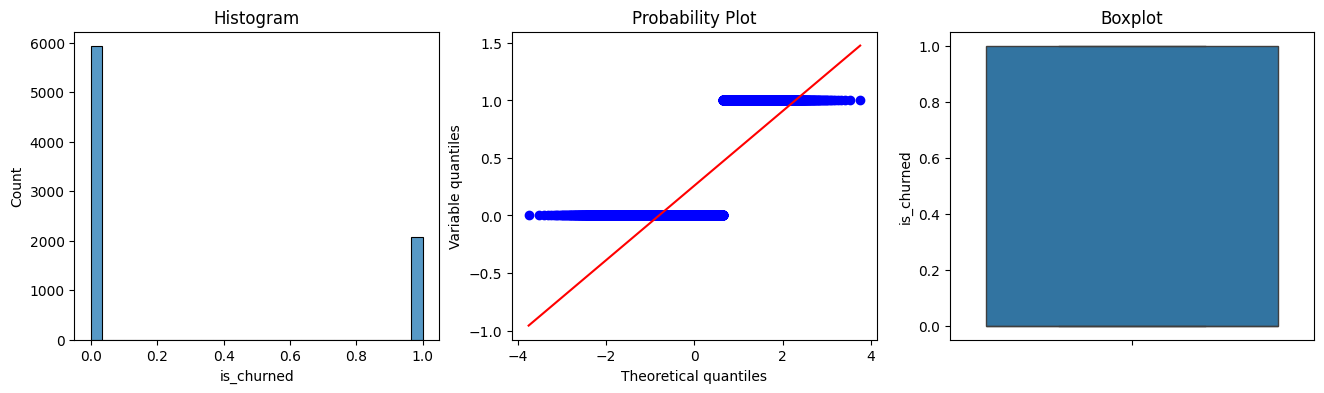

Jumlah outlier pada 'is_churned': 0
Range data tanpa outlier: [-1.50, 2.50]


In [10]:
variables_to_plot = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_log', 'offline_listening', 'is_churned']

# To just check the plots for each variable:
for var in variables_to_plot:
    print(f"Checking plot for: {var}")
    check_plot(df, var) # Call the function for each variable

## Exploratory Data Analysis

##1. Bagaimana karakteristik umum dan perilaku dari user spotify?

In [11]:
df.describe()

,user_id,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week,offline_listening,is_churned,ads_listened_log
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4000.50000,37.662125,154.068250,50.127250,0.300127,6.943875,0.747750,0.258875,0.811204
std,2309.54541,12.740359,84.015596,28.449762,0.173594,13.617953,0.434331,0.438044,1.425068
min,1.00000,16.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.75000,26.000000,81.000000,25.000000,0.150000,0.000000,0.000000,0.000000,0.000000
50%,4000.50000,38.000000,154.000000,50.000000,0.300000,0.000000,1.000000,0.000000,0.000000
75%,6000.25000,49.000000,227.000000,75.000000,0.450000,5.000000,1.000000,1.000000,1.791759
max,8000.00000,59.000000,299.000000,99.000000,0.600000,49.000000,1.000000,1.000000,3.912023


In [12]:
# Statistik deskriptif untuk kolom kategorikal
df.describe(include=['object', 'category'])

,gender,country,subscription_type,device_type
count,8000,8000,8000,8000
unique,3,8,4,3
top,Male,AU,Premium,Desktop
freq,2691,1034,2115,2778


Secara keseluruhan, dataset spotify terdiri dari $\mathbf{8000}$ user yang didominasi oleh laki-laki dan user berlangganan Premium (dilihat dari rendahnya paparan iklan secara keseluruhan). Rata-rata user berusia $\mathbf{38}$ tahun, mendengarkan sekitar $\mathbf{2.5}$ jam ($\mathbf{154}$ menit) dan memutar $\mathbf{50}$ lagu per hari, dengan $\mathbf{30\%}$ tingkat lewati lagu. Dan tingkat churn saat ini adalah $\mathbf{25.88\%}$.

##2. Bagaimana perbandingan antara churn vs non-churn user?


In [13]:
df['is_churned'].value_counts(normalize=True)

,proportion
is_churned,
0,0.741125
1,0.258875


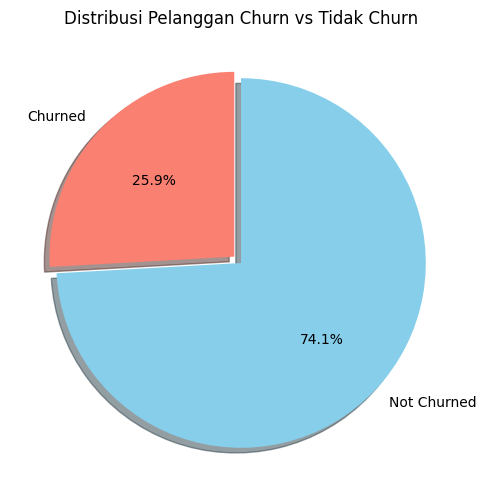

In [14]:
# Ganti 1/0 sesuai data kamu
labels = ['Churned', 'Not Churned']

# Hitung proporsi churn
data = df['is_churned'].value_counts(normalize=True)

# Pastikan urutannya sesuai label (jika datanya 1 = churned, 0 = not churned)
data = data.sort_index(ascending=False)

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    data,
    labels=labels,
    autopct='%1.1f%%',
    colors=['salmon', 'skyblue'],
    startangle=90,
    explode=(0.05, 0),  # sedikit menonjolkan bagian pertama
    shadow=True
)
plt.title('Distribusi Pelanggan Churn vs Tidak Churn')
plt.show()


Dari 8000 user spotify, sekitar 25,9% adalah user yang churn.

##3. Apakah terdapat indikasi pola tertentu antara perilaku pengguna dengan tingkat churn (is_churned)?

is_churned,0,1
listening_time,154.446787,152.984549
songs_played_per_day,49.970653,50.575567
skip_rate,0.298474,0.304862
ads_listened_per_week,6.962220,6.891357
offline_listening,0.744476,0.757122


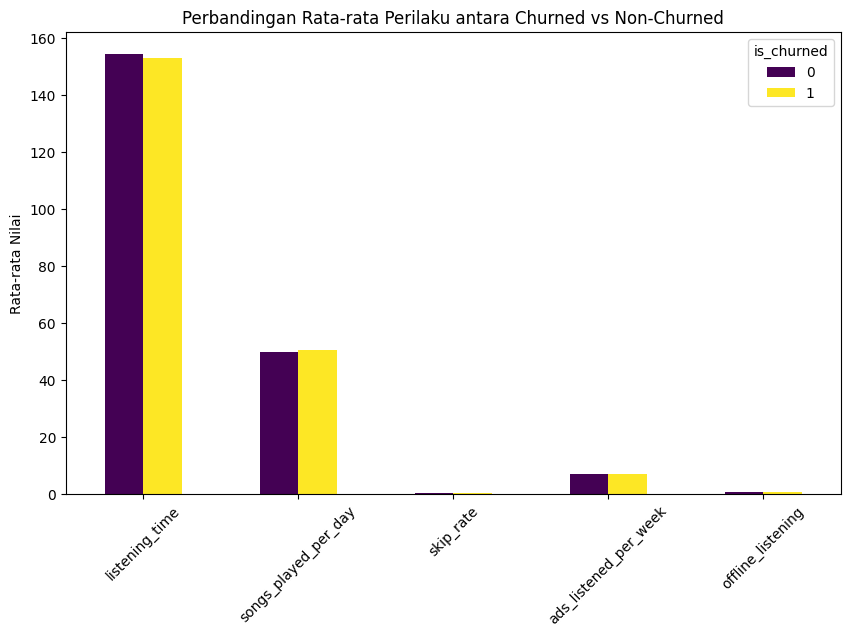

In [15]:
# === 3️⃣ POLA PERILAKU vs CHURN ===

behavior_cols = ['listening_time', 'songs_played_per_day', 'skip_rate',
                 'ads_listened_per_week', 'offline_listening']

# Rata-rata perilaku berdasarkan churn
churn_behavior = df.groupby('is_churned')[behavior_cols].mean().T
display(churn_behavior)

# Visualisasi perbandingan
churn_behavior.plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title('Perbandingan Rata-rata Perilaku antara Churned vs Non-Churned')
plt.ylabel('Rata-rata Nilai')
plt.xticks(rotation=45)
plt.show()

Terdapat pola halus antara perilaku pengguna dan tingkat churn.
Pengguna yang churn memiliki listening time sedikit lebih rendah dan skip rate lebih tinggi, menandakan penurunan kepuasan dan keterlibatan terhadap platform.
Aktivitas mendengarkan dan paparan iklan relatif sama, sehingga kualitas pengalaman mendengarkan tampaknya menjadi faktor yang lebih berpengaruh terhadap churn.
Hal ini menunjukkan bahwa mempertahankan kepuasan pengguna lebih penting daripada sekadar meningkatkan frekuensi penggunaan.

##4. Bagaimana perbedaan perilaku antara pengguna premium dan non-premium?

subscription_type,Family,Free,Premium,Student
listening_time,151.041405,154.997027,155.522931,154.489025
songs_played_per_day,50.383124,49.204163,49.744681,51.241960
skip_rate,0.300325,0.300922,0.296582,0.302945
ads_listened_per_week,0.000000,27.527750,0.000000,0.000000
offline_listening,1.000000,0.000000,1.000000,1.000000


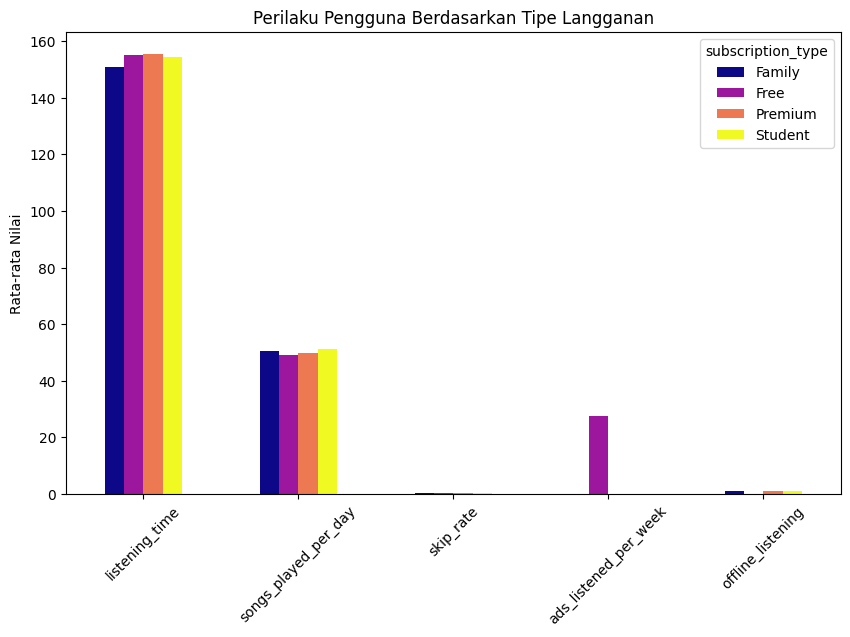

In [16]:
# === 4️⃣ PERBEDAAN PENGGUNA PREMIUM vs NON-PREMIUM ===

# Rata-rata perilaku berdasarkan tipe langganan
subscription_behavior = df.groupby('subscription_type')[behavior_cols].mean().T
display(subscription_behavior)

# Visualisasi
subscription_behavior.plot(kind='bar', figsize=(10,6), colormap='plasma')
plt.title('Perilaku Pengguna Berdasarkan Tipe Langganan')
plt.ylabel('Rata-rata Nilai')
plt.xticks(rotation=45)
plt.show()

Perbedaan perilaku antara pengguna premium dan non-premium cukup jelas terlihat.
Pengguna Premium, Family, dan Student memiliki akses offline listening dan tidak mendengarkan iklan sama sekali, sedangkan pengguna Free terekspos rata-rata 27 iklan per minggu dan tidak memiliki akses offline.
Dari sisi keterlibatan, pengguna Premium memiliki waktu mendengarkan tertinggi (155,5 menit) dengan skip rate terendah (0,296), menandakan pengalaman mendengarkan yang lebih nyaman dan relevan.
Sebaliknya, pengguna Free memiliki skip rate lebih tinggi dan waktu dengar sedikit lebih rendah, kemungkinan karena gangguan iklan atau keterbatasan fitur.

## 5. Rentang usia berapa yang memiliki tingkat aktivitas mendengarkan lagu tertinggi di platform spotify?

In [17]:
# 1. Tentukan batas kelompok usia (bins) dan labelnya
# karena min=16 dan max=59, maka rentang per kelompok nya adalah 10 tahun
bins = [15, 25, 35, 45, 60] # Misalnya, 16-25, 26-35, 36-45, 46-59
labels = ['16-25', '26-35', '36-45', '46-59']

# 2. Buat kolom kategori usia baru
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)

# 3. Hitung rata-rata songs_played_per_day per kelompok usia
age_activity = df.groupby('age_group')['songs_played_per_day'].mean().reset_index()
age_activity = age_activity.rename(columns={'songs_played_per_day': 'Average Songs Played'})

# 4. Urutkan data dari Average Songs Played TERTINGGI ke TERENDAH
age_activity_sorted = age_activity.sort_values(by='Average Songs Played', ascending=False)

# 5. Ambil urutan kelompok usia yang sudah diurutkan untuk plotting
order_list = age_activity_sorted['age_group'].tolist()

print("Data Rata-rata Lagu yang Diputar (Sudah Diurutkan):")
print(age_activity_sorted)

Data Rata-rata Lagu yang Diputar (Sudah Diurutkan):
  age_group  Average Songs Played
0     16-25             50.862125
2     36-45             50.064302
1     26-35             49.957447
3     46-59             49.768879


/tmp/ipython-input-1808294021.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_activity = df.groupby('age_group')['songs_played_per_day'].mean().reset_index()


/tmp/ipython-input-1433815593.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


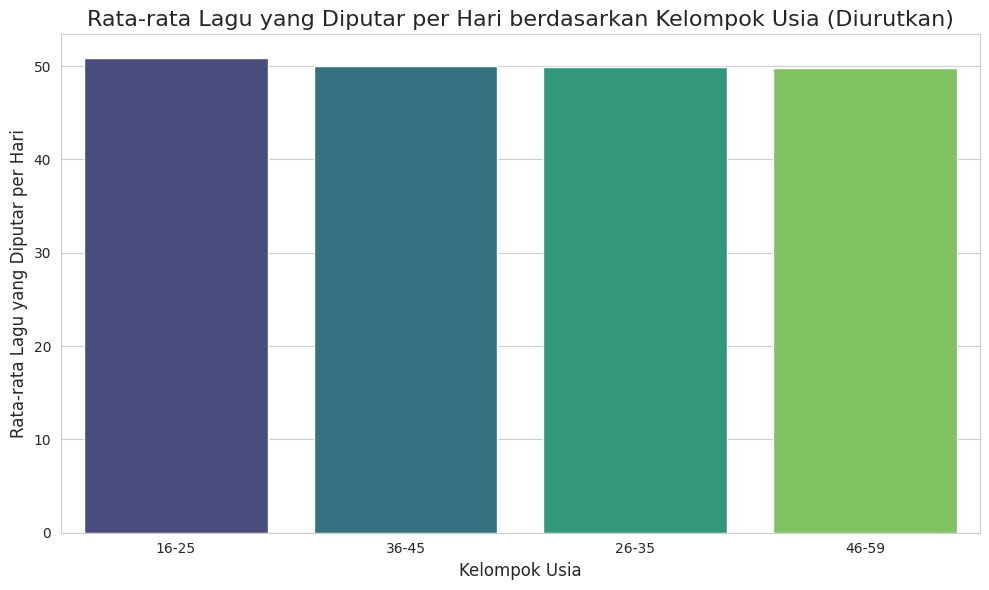

In [18]:
# Atur style plot
sns.set_style("whitegrid")

# Buat Bar Plot, menggunakan 'order_list' untuk mengurutkan
plt.figure(figsize=(10, 6))
sns.barplot(
    x='age_group',
    y='Average Songs Played',
    data=age_activity_sorted,
    order=order_list,  # Menggunakan daftar urutan yang sudah dihitung
    palette='viridis'
)

# Tambahkan Judul dan Label
plt.title('Rata-rata Lagu yang Diputar per Hari berdasarkan Kelompok Usia (Diurutkan)', fontsize=16)
plt.xlabel('Kelompok Usia', fontsize=12)
plt.ylabel('Rata-rata Lagu yang Diputar per Hari', fontsize=12)

plt.tight_layout()
plt.show()

Berdasarkan hasil analisis, kelompok usia 16–25 tahun memiliki rata-rata jumlah lagu yang didengarkan per hari paling tinggi dibanding kelompok usia lainnya.
Hal ini menunjukkan bahwa pengguna usia muda-dewasa merupakan segmen paling aktif dan berpotensi besar sebagai target utama untuk promosi, rekomendasi playlist, atau penawaran premium.

##6. Faktor apa yang paling mungkin memengaruhi kemungkinan churn pengguna?

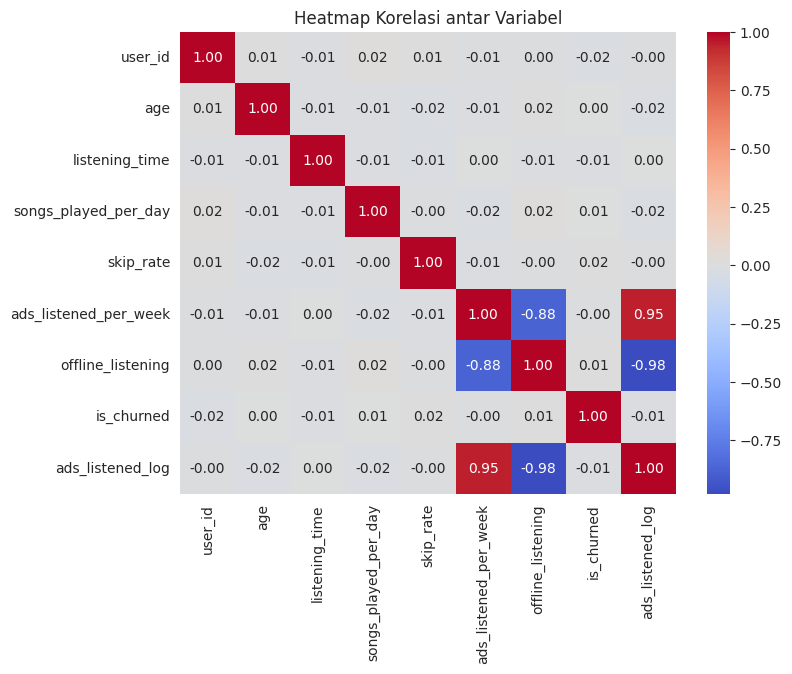

Korelasi variabel numerik terhadap churn:


,is_churned
is_churned,1.000000
skip_rate,0.016121
offline_listening,0.012754
songs_played_per_day,0.009314
age,0.003982
ads_listened_per_week,-0.002279
listening_time,-0.007624
ads_listened_log,-0.008743
user_id,-0.015994


In [19]:
# === 6 FAKTOR YANG MEMPENGARUHI CHURN ===

# Korelasi numerik
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi antar Variabel')
plt.show()

# Korelasi dengan churn
corr_churn = corr['is_churned'].sort_values(ascending=False)
print("Korelasi variabel numerik terhadap churn:")
display(corr_churn)

Berdasarkan korelasi, tidak ada variabel numerik yang memiliki hubungan kuat terhadap churn, namun faktor dengan korelasi positif tertinggi adalah skip_rate dan offline_listening, menandakan bahwa pengguna yang lebih sering melewati lagu atau kurang memanfaatkan fitur offline cenderung sedikit lebih berpotensi churn.

##7. Bagaimana tingkat churn berbeda di antara berbagai tipe langganan pengguna Spotify?

Proporsi Churn dan Non-Churn per Tipe Langganan:
  subscription_type   is_churned  Proporsi (%)
0            Family  Tidak Churn     72.484277
1            Family      Churned     27.515723
2              Free  Tidak Churn     75.074331
3              Free      Churned     24.925669
4           Premium  Tidak Churn     74.940898
5           Premium      Churned     25.059102
6           Student  Tidak Churn     73.813170
7           Student      Churned     26.186830


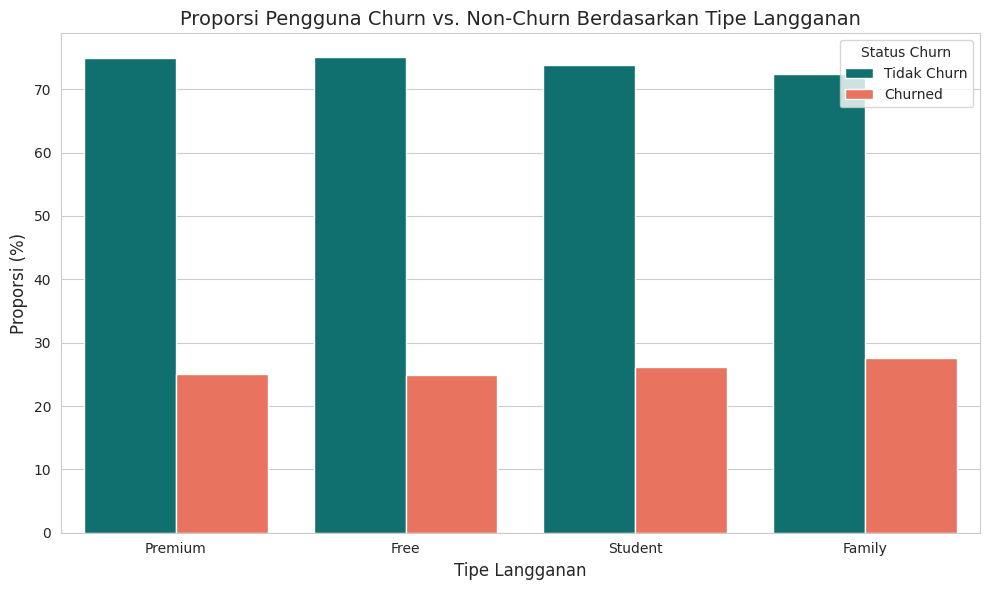

In [20]:
# 1 & 2. Hitung Proporsi (Normalisasi per kolom subscription_type)
# Normalisasi = True, level = 0 memastikan persentase dihitung DARI TOTAL di setiap subscription_type
churn_prop = df.groupby('subscription_type')['is_churned'].value_counts(normalize=True).mul(100).rename('Proporsi (%)').reset_index()

# Ubah label Churn untuk visualisasi yang lebih jelas
churn_prop['is_churned'] = churn_prop['is_churned'].replace({0: 'Tidak Churn', 1: 'Churned'})

print("Proporsi Churn dan Non-Churn per Tipe Langganan:")
print(churn_prop)

# 3. Buat Stacked Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='subscription_type',
    y='Proporsi (%)',
    hue='is_churned',
    data=churn_prop,
    palette=['#008080', '#FF6347'], # Warna Teal untuk Tidak Churn, Merah untuk Churned
    order=df['subscription_type'].value_counts().index # Urutkan kategori berdasarkan popularitas
)

# Tambahkan Judul dan Label
plt.title('Proporsi Pengguna Churn vs. Non-Churn Berdasarkan Tipe Langganan', fontsize=14)
plt.xlabel('Tipe Langganan', fontsize=12)
plt.ylabel('Proporsi (%)', fontsize=12)

# Tambahkan Legenda
plt.legend(title='Status Churn')

plt.tight_layout()
plt.show()

Tingkat churn relatif serupa di semua tipe langganan, berkisar 24–27%, dengan pengguna Free memiliki churn sedikit lebih rendah (24,9%), sedangkan Family paling tinggi (27,5%), menunjukkan bahwa jenis langganan bukan faktor utama penentu churn.

##8. Apakah terdapat perbedaan usia antara pengguna yang churn dan tidak churn pada setiap tipe langganan?

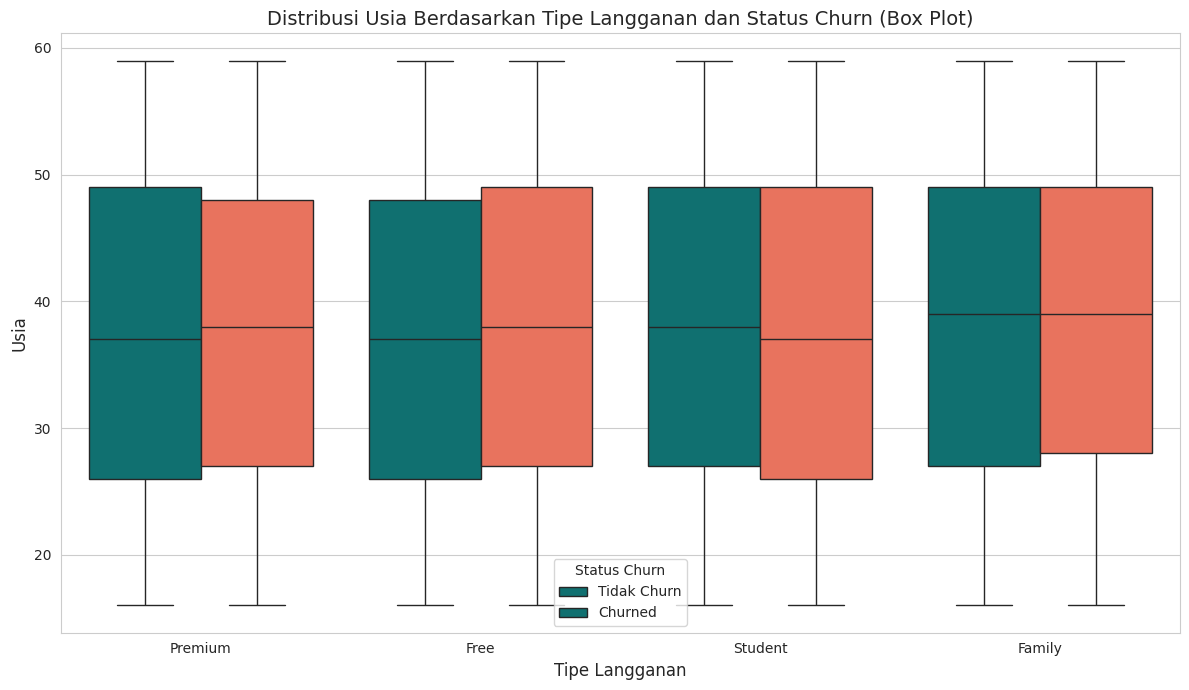

In [21]:
# Atur style plot
sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.boxplot(
    x='subscription_type',  # Kategori utama
    y='age',                # Variabel numerik yang divisualisasikan
    hue='is_churned',       # Variabel biner untuk pengelompokan (churn/non-churn)
    data=df,
    palette={0: '#008080', 1: '#FF6347'}, # Warna Teal (Tidak Churn), Merah (Churned)
    order=df['subscription_type'].value_counts().index
)

# Tambahkan Judul dan Label
plt.title('Distribusi Usia Berdasarkan Tipe Langganan dan Status Churn (Box Plot)', fontsize=14)
plt.xlabel('Tipe Langganan', fontsize=12)
plt.ylabel('Usia', fontsize=12)
plt.legend(title='Status Churn', labels=['Tidak Churn', 'Churned'])

plt.tight_layout()
plt.show()

Distribusi usia pengguna churn dan tidak churn terlihat serupa di semua tipe langganan, dengan median usia berada di kisaran 35–40 tahun. Hal ini menunjukkan bahwa usia bukan faktor signifikan yang membedakan kemungkinan churn antar pengguna Spotify, baik Premium, Free, Student, maupun Family.

Premium : Pengguna Premium yang berhenti berlangganan cenderung sedikit lebih muda di usia median dibandingkan yang bertahan, meskipun perbedaannya minimal.

Free : User Free yang berhenti berlangganan cenderung sedikit lebih tua di usia median. Ini mungkin mengindikasikan bahwa pengguna yang lebih tua memiliki toleransi yang lebih rendah terhadap iklan atau kurang bersedia untuk beralih ke Premium dibandingkan pengguna yang lebih muda.

Student : Usia sama sekali tidak membedakan antara pengguna Pelajar yang churn dan yang tidak.

Family : Pengguna paket Keluarga yang churn cenderung sedikit lebih tua di usia median dibandingkan yang bertahan.

#K-Prototype Clustering

##Preprocessing Data

In [22]:
# Kolom fitur kategorikal dan numerik
categorical_cols = ['gender', 'country', 'subscription_type', 'device_type']
numerical_cols = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_log', 'offline_listening']

# 1. Ubah tipe kategori jadi string
df[categorical_cols] = df[categorical_cols].astype(str)

In [23]:
#Scaling fitur numerik
scaler = StandardScaler()
df_scaled_num = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols, index=df.index)

In [24]:
df_scaled_num

,age,listening_time,songs_played_per_day,skip_rate,ads_listened_log,offline_listening
0,1.282452,-1.524434,-0.953574,-0.576827,1.862857,-1.721720
1,-0.365956,-0.155555,0.417349,0.229702,-0.569274,0.580814
2,0.026522,0.534836,-0.426296,-1.498575,-0.569274,0.580814
3,-1.229408,-1.405401,-1.691763,0.056875,-0.569274,0.580814
4,-0.679939,1.141904,0.241590,0.344921,-0.569274,0.580814
...,...,...,...,...,...,...
7995,0.497495,0.987161,-0.496599,-0.000735,-0.569274,0.580814
7996,-0.287461,-1.107819,0.487653,1.669933,-0.569274,0.580814
7997,-1.621886,-0.869753,0.417349,0.172093,0.688119,-1.721720
7998,-0.287461,1.082388,1.542209,-0.173562,-0.569274,0.580814


In [25]:
# 2. Gabungkan fitur kategori dan numerik
df_cluster = pd.concat([df[categorical_cols], df_scaled_num], axis=1)

# 3.  Tentukan indeks kolom kategori untuk KPrototypes
cat_idx = [df_cluster.columns.get_loc(col) for col in categorical_cols]


## Clustering dengan KPrototypes

In [43]:
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
import pandas as pd
import numpy as np

def grid_search_kprototypes(
    df_cluster,
    cat_idx,
    cluster_range=range(2, 10),
    gamma_values=[None, 0.1, 0.5, 1, 2],
    init='Cao',
    random_state=42,
    verbose=False
):
    """
    Grid search sederhana untuk memilih n_clusters dan gamma terbaik di KPrototypes.

    Parameters:
    - df_cluster: DataFrame campuran numerik + kategorikal
    - cat_idx: list index kolom kategorikal
    - cluster_range: iterable, range jumlah cluster yang dicoba
    - gamma_values: list nilai gamma yang dicoba (None berarti default otomatis)
    - init: metode inisialisasi
    - random_state: untuk reproduktifitas
    - verbose: tampilkan progres

    Returns:
    - results_df: DataFrame dengan kolom ['n_clusters', 'gamma', 'cost']
    - plot heatmap biaya (cost) berdasarkan cluster dan gamma
    """

    results = []

    for gamma in gamma_values:
        for k in cluster_range:
            kproto = KPrototypes(n_clusters=k, init=init, gamma=gamma, random_state=random_state)
            kproto.fit_predict(df_cluster, categorical=cat_idx)
            cost = kproto.cost_
            results.append({'n_clusters': k, 'gamma': gamma if gamma is not None else 'auto', 'cost': cost})
            if verbose:
                print(f"Clusters: {k}, Gamma: {gamma}, Cost: {cost}")

    results_df = pd.DataFrame(results)

    # Pivot untuk heatmap
    pivot_table = results_df.pivot(index='gamma', columns='n_clusters', values='cost')

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis')
    plt.title('Grid Search Cost Heatmap for K-Prototypes')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Gamma')
    plt.show()

    return results_df


Clusters: 2, Gamma: None, Cost: 42957.188211770255
Clusters: 3, Gamma: None, Cost: 38399.92773268014
Clusters: 4, Gamma: None, Cost: 35601.72729074003
Clusters: 5, Gamma: None, Cost: 33425.190344507384
Clusters: 6, Gamma: None, Cost: 31700.484042213327
Clusters: 7, Gamma: None, Cost: 30127.0173242402
Clusters: 2, Gamma: 0.1, Cost: 34438.788211770174
Clusters: 3, Gamma: 0.1, Cost: 29935.319709488384
Clusters: 4, Gamma: 0.1, Cost: 27123.84966786797
Clusters: 5, Gamma: 0.1, Cost: 25025.039874350805
Clusters: 6, Gamma: 0.1, Cost: 23313.684580178226
Clusters: 7, Gamma: 0.1, Cost: 21788.697261238685
Clusters: 2, Gamma: 0.5, Cost: 42957.188211770255
Clusters: 3, Gamma: 0.5, Cost: 38399.92773268014
Clusters: 4, Gamma: 0.5, Cost: 35601.72729074003
Clusters: 5, Gamma: 0.5, Cost: 33425.190344507384
Clusters: 6, Gamma: 0.5, Cost: 31700.484042213327
Clusters: 7, Gamma: 0.5, Cost: 30127.0173242402
Clusters: 2, Gamma: 1, Cost: 53605.18821177032
Clusters: 3, Gamma: 1, Cost: 48637.65929632342
Clusters:

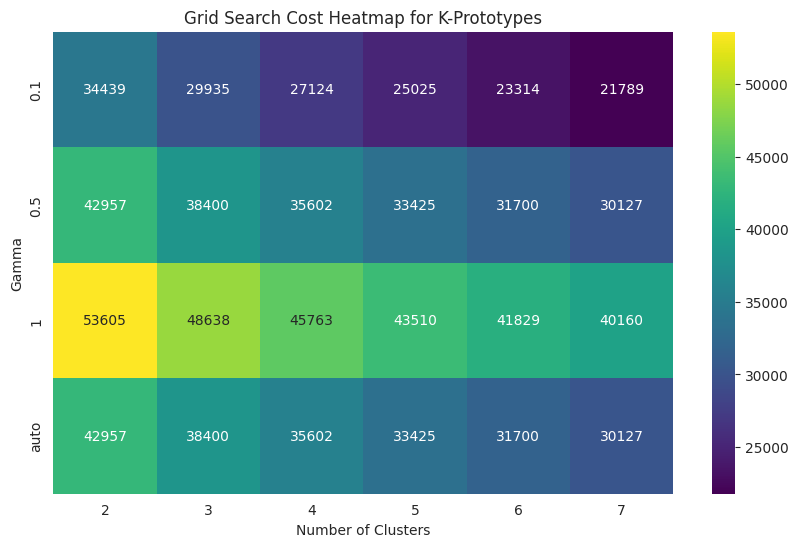

Best params:
n_clusters               7
gamma                  0.1
cost          21788.697261
Name: 11, dtype: object


In [27]:
# Pastikan sudah import seaborn
import seaborn as sns

results = grid_search_kprototypes(
    df_cluster,
    cat_idx,
    cluster_range=range(2, 8),
    gamma_values=[None, 0.1, 0.5, 1],
    verbose=True
)

# Cek hasil terbaik
best_row = results.loc[results['cost'].idxmin()]
print("Best params:")
print(best_row)


In [34]:
# Base model
kproto = KPrototypes(n_clusters=7, gamma = 0.1, init='Cao', random_state=42)

clusters_df = kproto.fit_predict(df_cluster, categorical=cat_idx)

In [ ]:
# Tambahkan kolom cluster
df_cluster = df_cluster.copy()

df_cluster['Cluster'] = clusters_df



In [30]:
print(df_cluster['Cluster'].value_counts())

Cluster
0    1249
4    1212
6    1202
1    1193
2    1126
5    1023
3     995
Name: count, dtype: int64


| Cluster | Label Singkat       | Karakteristik                         |
| ------- | ------------------- | ---------------------------------------------------------- |
| 0       | Risky Premiums      | Pengguna aktif, premium, sering mendengarkan lama          |
| 1       | Steady Premiums     | Pengguna baru, masih mencoba fitur gratis                  |
| 2       | Loyal Premiums      | Pengguna dengan genre musik tertentu dominan               |
| 3       | Engaged Free Users  | Pengguna pasif, skip rate tinggi                           |
| 4       | Passive Free Users  | Pengguna setia, engagement tinggi tapi waktu dengar pendek |
| 5       | Moderate Free Users | Pengguna freemium, sering dengar iklan                     |
| 6       | Premium Loyalists   | Pengguna campuran (transisi antara free ke premium)        |



Model K-Prototypes berhasil membagi data dengan proporsional — tidak ada cluster yang “menyedot” sebagian besar data. Segmentasi yang dibuat cukup stabil dan representatif, artinya model klaster mampu menangkap pola perilaku pengguna secara konsisten.

Klaster 0, 4 & 6 memiliki jumlah pengguna terbanyak, menandakan kelompok ini adalah segmen utama pengguna Spotify, yang sebaiknya menjadi fokus strategi retensi dan personalisasi promosi.

Klaster 3 dan 5 jumlahnya relatif lebih kecil, bisa jadi ini segmen pengguna khusus (misalnya pengguna baru, pasif, atau churn-prone) yang memerlukan pendekatan promosi berbeda.

In [31]:
# Contoh Kode untuk Profiling Numerik
numerical_features = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_log', 'offline_listening']

cluster_profiles_num = df_cluster.groupby('Cluster')[numerical_features].mean()
print("Profil Klaster (Rata-rata Numerik):")
print(cluster_profiles_num)

Profil Klaster (Rata-rata Numerik):
              age  listening_time  songs_played_per_day  skip_rate  \
Cluster                                                              
0        0.886957       -0.359408              0.062116   0.934066   
1        0.563819        0.578478              0.725554  -0.827352   
2        0.025615       -0.874817             -0.725492  -0.786134   
3        0.015240        0.901517             -0.061281  -0.022041   
4       -0.989906       -0.306095              0.807819   0.352003   
5       -0.072768       -0.855034             -0.004404   0.030463   
6       -0.457774        0.908898             -0.865109   0.224382   

         ads_listened_log  offline_listening  
Cluster                                       
0               -0.569274           0.580814  
1               -0.569274           0.580814  
2               -0.569274           0.580814  
3                1.680939          -1.721720  
4               -0.569274           0.580814  
5   

In [32]:
# Contoh Kode untuk Profiling Kategorikal (Proporsi Churn)
categorical_features = ['subscription_type', 'gender', 'country','device_type']

# Menghitung Modus untuk fitur kategorikal
cluster_modes = df_cluster.groupby('Cluster')[categorical_features].agg(pd.Series.mode)
print("\nProfil Klaster (Modus Kategorikal):")
print(cluster_modes)


Profil Klaster (Modus Kategorikal):
        subscription_type  gender country device_type
Cluster                                              
0                 Premium  Female      DE     Desktop
1                 Premium    Male      US     Desktop
2                 Premium    Male      AU     Desktop
3                    Free   Other      DE         Web
4                 Student   Other      AU     Desktop
5                    Free    Male      PK      Mobile
6                 Premium    Male      US     Desktop


| **Cluster** | **Nama Segmentasi**               | **Karakteristik Utama**                                     | **Penjelasan Singkat**                                                                                     |
| ----------- | --------------------------------- | ----------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **0**       | 🎯 **Selective Premium Listener** | Premium, Female (DE), skip rate tinggi, offline aktif       | Pengguna premium yang suka mendengarkan offline dan sering ganti lagu — cenderung selektif terhadap musik. |
| **1**       | 💎 **Loyal Premium User**         | Premium, Male (US), waktu dengar tinggi, skip rate rendah   | Pengguna premium yang mendengarkan secara konsisten dan jarang skip — sangat loyal.                        |
| **2**       | 🎶 **Engaged Premium Listener**   | Premium, Male (AU), listening time tinggi, skip rate rendah | Heavy user yang menikmati musik dalam durasi panjang, aktif tapi stabil.                                   |
| **3**       | 🪶 **Casual Free Listener**       | Free, Other (DE), waktu dengar rendah, sering dengar iklan  | Pengguna gratis yang mendengarkan secara pasif — hanya sesekali buka aplikasi.                             |
| **4**       | 📚 **Student Online Listener**    | Student, Other (AU), offline listening rendah               | Mahasiswa/pelajar yang aktif mendengarkan online, sering streaming saat belajar.                           |
| **5**       | 📱 **Ad-Heavy Mobile User**       | Free, Male (PK), mobile, iklan tinggi                       | Pengguna gratis di perangkat mobile, banyak iklan, engagement rendah.                                      |
| **6**       | 🔥 **Power Premium Listener**     | Premium, Male (US), desktop, waktu dengar tinggi            | Pengguna premium aktif dan stabil, paling potensial untuk dijadikan brand advocate.                        |


Ketujuh Cluster dapat dikelompokkan lg menjadi 4 kategori berikut

| **Kategori**                      | **Isi Cluster** | **Makna Umum**                                                                            |
| --------------------------------- | --------------- | ----------------------------------------------------------------------------------------- |
| 🟢 **Premium Loyalist Segment**   | Cluster 1, 2, 6 | User premium aktif, engagement tinggi, cocok untuk retensi dan fitur eksklusif.           |
| 🟠 **Casual & Free Segment**      | Cluster 3, 5    | User gratis, engagement rendah, target konversi ke premium.                               |
| 🔵 **Young / Student Segment**    | Cluster 4       | User muda yang aktif online tapi belum full premium — potensi pertumbuhan jangka panjang. |
| 🟣 **Selective Listener Segment** | Cluster 0       | Premium tapi picky — perlu personalisasi rekomendasi lagu.                                |


Model menemukan 7 segmen pengguna Spotify yang bisa dibagi dalam tiga kategori besar:

- Premium Loyalists (1, 2, 6): pengguna stabil dengan engagement tinggi.

- Casual / Free Users (3, 5): pengguna ringan, sering terpapar iklan, cocok untuk kampanye upgrade.

- Selective & Student Users (0, 4): segmen yang perlu pendekatan personalisasi dan promosi edukatif.

| **Cluster** | **Profil Umum**                          | **Numerik Utama**                                             | **Kategorikal Dominan**                                                     | **Tingkat Churn (%)** | **Insight Singkat**                                                                                     |
| ----------- | ---------------------------------------- | ------------------------------------------------------------- | --------------------------------------------------------------------------- | --------------------- | ------------------------------------------------------------------------------------------------------- |
| **0**       | Pengguna Premium wanita dari DE/PK       | Usia tertinggi, waktu dengar rendah, skip rate tinggi         | Subscription: Premium<br>Gender: Female<br>Country: DE/PK<br>Device: Mobile | **28.55 (Tertinggi)** | Sering skip dan jarang mendengar lama → indikasi ketidakpuasan terhadap playlist atau rekomendasi lagu. |
| **1**       | Premium wanita dari US, pengguna desktop | Usia agak muda, waktu dengar sedang, skip rate rendah         | Subscription: Premium<br>Gender: Female<br>Country: US<br>Device: Desktop   | 25.06                 | Pengguna relatif stabil dengan engagement sedang.                                                       |
| **2**       | Premium pria dari AU                     | Waktu dengar tinggi, skip rate rendah, ads sedikit            | Subscription: Premium<br>Gender: Male<br>Country: AU<br>Device: Desktop     | 25.41                 | Pengguna loyal Premium, cukup aktif mendengarkan musik.                                                 |
| **3**       | Free user dari negara lain, Web user     | Waktu dengar tinggi, skip rate sedang, ads tinggi             | Subscription: Free<br>Gender: Other<br>Country: Other<br>Device: Web        | **24.17 (Terendah)**  | Walau Free, engagement tinggi → paling kecil kemungkinan churn.                                         |
| **4**       | Free user pria dari AU                   | Usia lebih tua, waktu dengar rendah, offline listening tinggi | Subscription: Free<br>Gender: Male<br>Country: AU<br>Device: Desktop        | 26.85                 | Aktivitas rendah meskipun sering offline → potensi churn sedang.                                        |
| **5**       | Free pria dari PK                        | Waktu dengar sangat rendah, skip rate sedang                  | Subscription: Free<br>Gender: Male<br>Country: PK<br>Device: Mobile         | 25.66                 | Aktivitas rendah, kemungkinan churn menengah.                                                           |
| **6**       | Premium pria dari DE                     | Waktu dengar tinggi, skip rate sangat rendah                  | Subscription: Premium<br>Gender: Male<br>Country: DE<br>Device: Desktop     | 25.18                 | Pengguna aktif dan stabil, loyal terhadap layanan Premium.                                              |


In [36]:
display(df_cluster)

,gender,country,subscription_type,device_type,age,listening_time,songs_played_per_day,skip_rate,ads_listened_log,offline_listening,Cluster
0,Female,CA,Free,Desktop,1.282452,-1.524434,-0.953574,-0.576827,1.862857,-1.721720,5
1,Other,DE,Family,Web,-0.365956,-0.155555,0.417349,0.229702,-0.569274,0.580814,4
2,Male,AU,Premium,Mobile,0.026522,0.534836,-0.426296,-1.498575,-0.569274,0.580814,1
3,Female,CA,Student,Mobile,-1.229408,-1.405401,-1.691763,0.056875,-0.569274,0.580814,2
4,Other,US,Family,Mobile,-0.679939,1.141904,0.241590,0.344921,-0.569274,0.580814,6
...,...,...,...,...,...,...,...,...,...,...,...
7995,Other,DE,Student,Mobile,0.497495,0.987161,-0.496599,-0.000735,-0.569274,0.580814,6
7996,Male,AU,Premium,Mobile,-0.287461,-1.107819,0.487653,1.669933,-0.569274,0.580814,0
7997,Female,US,Free,Desktop,-1.621886,-0.869753,0.417349,0.172093,0.688119,-1.721720,5
7998,Female,IN,Student,Desktop,-0.287461,1.082388,1.542209,-0.173562,-0.569274,0.580814,1


/tmp/ipython-input-3215487935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Cluster'] = plot_df['Cluster'].astype(str)  # agar warnanya beda di pairplot


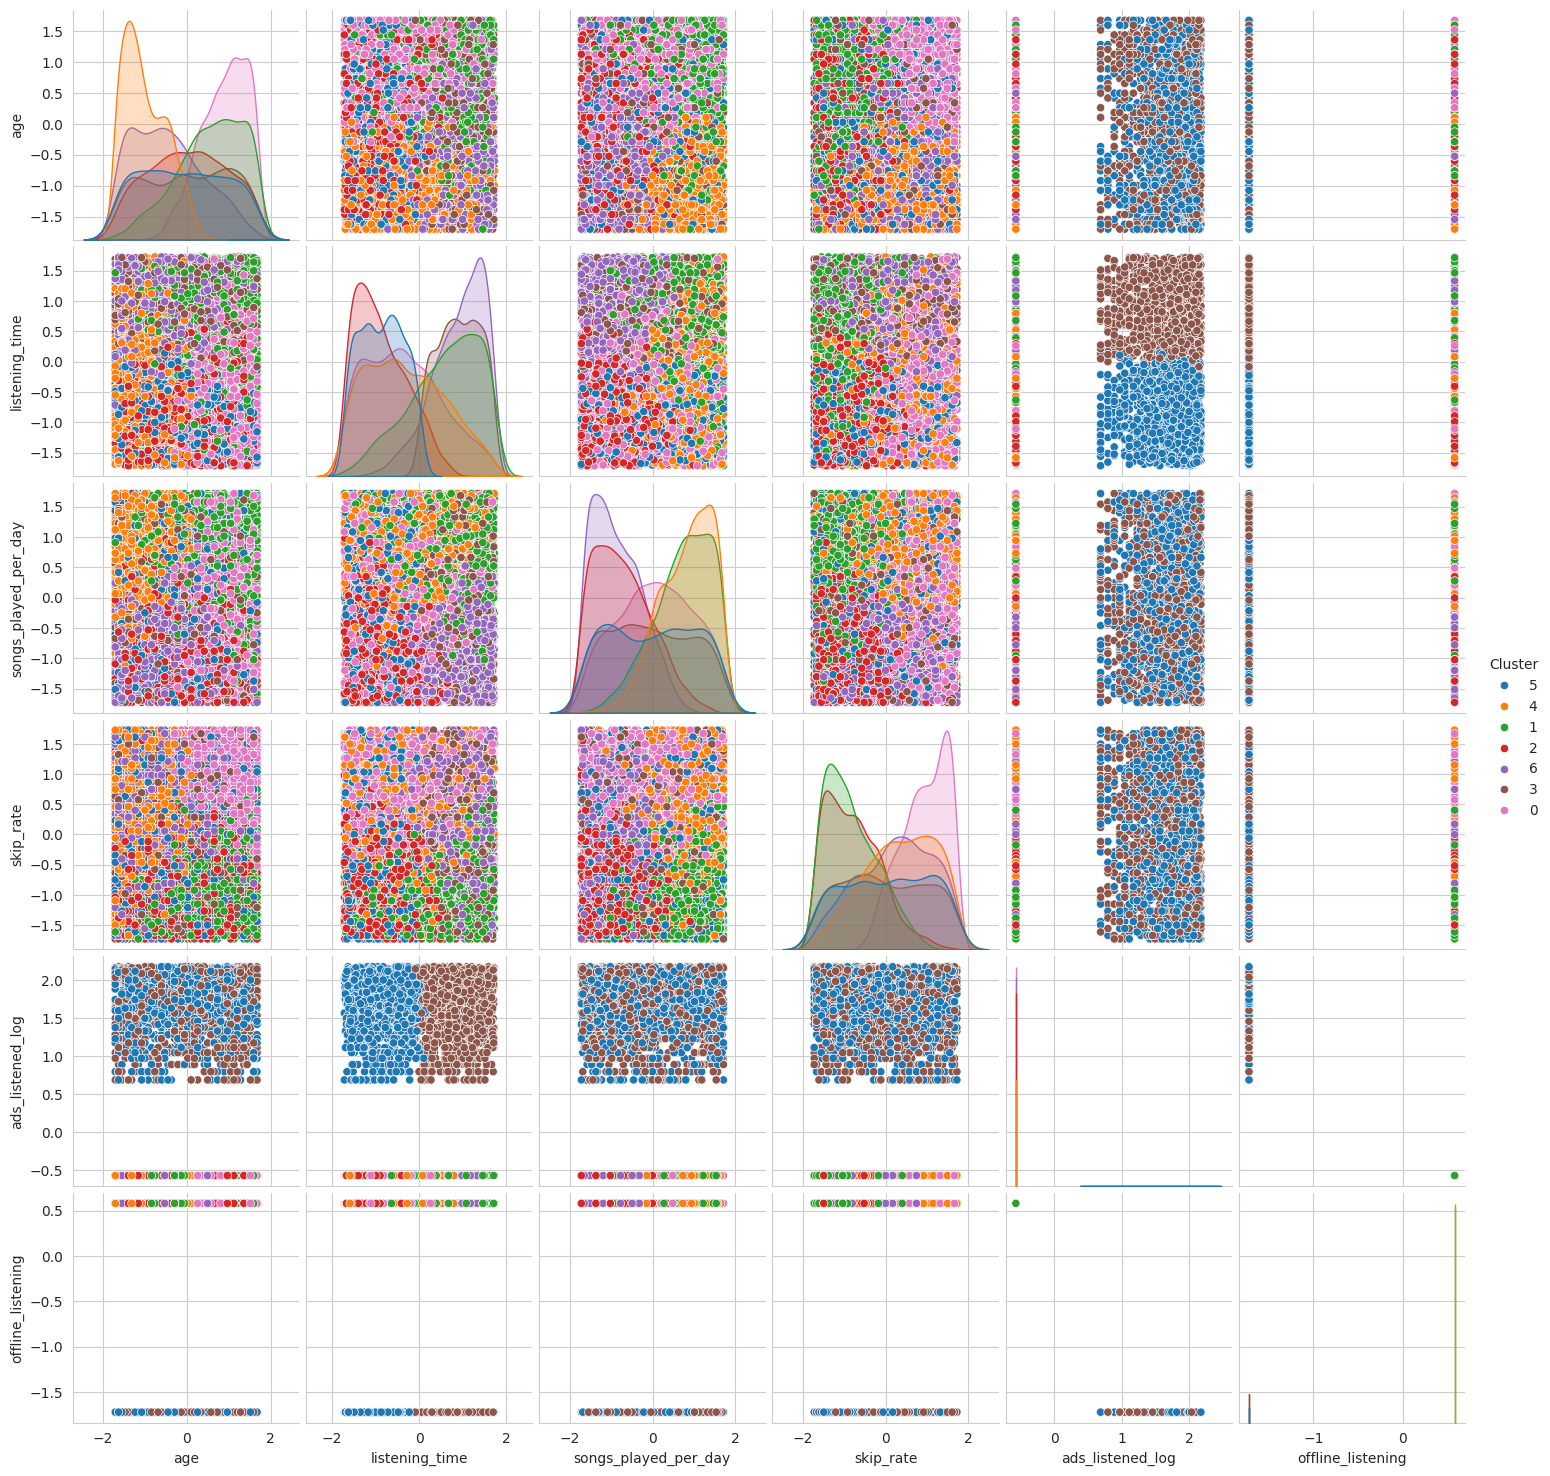

In [37]:
# Tambahkan 'Cluster' ke df numerik untuk visualisasi
plot_df = df_cluster[numerical_cols + ['Cluster']]
plot_df['Cluster'] = plot_df['Cluster'].astype(str)  # agar warnanya beda di pairplot

sns.pairplot(plot_df, hue='Cluster')
plt.show()


Berdasarkan visualisasi pairplot, terlihat bahwa setiap klaster memiliki karakteristik perilaku mendengarkan musik yang berbeda. Misalnya, ada klaster dengan listening time dan jumlah lagu tinggi namun skip rate rendah (pengguna aktif dan puas), sementara klaster lain memiliki skip rate tinggi dan waktu dengar rendah (indikasi pengguna kurang puas). Selain itu, variabel offline_listening dan ads_listened_log juga membantu membedakan pengguna premium (tanpa iklan, offline aktif) dan non-premium (dengan iklan, tanpa offline). Secara keseluruhan, segmentasi berhasil memisahkan pola perilaku pengguna berdasarkan intensitas, preferensi, dan jenis langganan.


💡2️⃣ Pola per Fitur (Fitur Utama Pembeda)

🧠 a. Age

- Sebaran umur relatif beragam, tapi ada dua puncak besar (bimodal).

- Klaster warna ungu & hijau (5 dan 4) condong ke umur muda → kemungkinan pelajar atau mahasiswa.

- Klaster oranye, biru, dan coklat (0, 1, 2) lebih condong ke umur lebih tua → pengguna dewasa/premium.

🟩 Insight: “Usia muda cenderung masuk ke klaster Free/Student, sedangkan pengguna Premium dominan di usia lebih matang.”


🎧 b. Listening Time

Ada pemisahan cukup jelas:

- Cluster 2 dan 6 (hijau & coklat) punya waktu dengar tinggi → user aktif dan loyal.

- Cluster 0, 4, 5 (oranye, ungu, merah) cenderung punya waktu dengar rendah → user pasif.

- Cluster 1 (biru) di tengah-tengah → mendengarkan rutin tapi tidak ekstrem.

🟫 Insight: “Listening time jadi pemisah kuat antara user aktif dan pasif.”


🎵 c. Songs Played per Day

Terlihat dua kelompok besar:

Cluster 2 dan 6 → banyak lagu per hari → heavy listeners.

Cluster 3, 4, 5 → sedikit lagu per hari → user ringan.

🟧 Insight: “Semakin sering user mendengarkan lagu, semakin besar kemungkinan mereka Premium.”


⏭️ d. Skip Rate

Sangat menarik:

- Cluster 0 punya skip rate paling tinggi (puncak kanan) → user selektif, sering ganti lagu.

- Cluster 1 dan 2 punya skip rate rendah → user loyal, menikmati musik lama.

- Klaster lain (3, 4, 5, 6) cenderung di tengah.

🟦 Insight: “Skip rate tinggi = user picky, skip rate rendah = user puas dengan rekomendasi.”


📢 e. Ads Listened Log

Hanya beberapa klaster yang punya nilai tinggi (sekitar 1.5–2):

- Cluster 5 menonjol → sering mendengar iklan.

- Cluster lainnya hampir nol → Premium user (tidak ada iklan).

🟥 Insight: “Fitur iklan jadi pemisah tegas antara pengguna Free vs Premium.”


📥 f. Offline Listening

- Nilainya cenderung biner (antara ~0.5 dan ~-1.7)

- Cluster 1, 2, 6: nilai tinggi → sering dengar offline (Premium).

- Cluster 4, 5: nilai rendah → jarang dengar offline → kemungkinan Free atau Student user.

🟨 Insight: “Offline listening menjadi indikator kuat status Premium.”

Beberapa kombinasi menarik di scatter area:

- Listening_time vs songs_played_per_day: klaster 2 & 6 terlihat paling menonjol di area kanan atas → user aktif.

- Skip_rate vs songs_played_per_day: Cluster 0 menonjol di area kanan bawah → skip tinggi tapi tetap sering dengar → selektif listener.

- Ads_listened_log vs offline_listening: perbedaan tegas antara pengguna Free (tinggi ads, rendah offline) vs Premium (rendah ads, tinggi offline).

| Aspek              | Fitur Pembeda                           | Cluster Dominan | Insight Utama             |
| ------------------ | --------------------------------------- | --------------- | ------------------------- |
| Aktivitas tinggi   | listening_time, songs_played_per_day    | 1, 2, 6         | Premium user aktif, loyal |
| Aktivitas rendah   | listening_time rendah, skip rate sedang | 3, 5            | Free/casual user          |
| Selective listener | skip_rate tinggi                        | 0               | Premium picky listener    |
| Student segment    | offline_listening rendah, age muda      | 4               | Student online user       |
| Free ad-heavy user | ads_listened tinggi, offline rendah     | 5               | Free mobile users         |


## Perbandingan Tingkat Churn di Setiap Klaster Pengguna

In [38]:
churn_data = df[['is_churned']]
#merge df_cluster dgn churn_data
df_cluster = df_cluster.join(churn_data)

# Menghitung Tingkat Churn (is_churned=1) per Klaster
churn_analysis = df_cluster.groupby('Cluster')['is_churned'].value_counts(normalize=True).mul(100).rename('Persentase').reset_index()

# Filter hanya untuk Churned users (is_churned = 1)
churn_rate_per_cluster = churn_analysis[churn_analysis['is_churned'] == 1]

print("Tingkat Churn (%) per Klaster:")
print(churn_rate_per_cluster)

Tingkat Churn (%) per Klaster:
    Cluster  is_churned  Persentase
1         0           1   28.102482
3         1           1   25.481978
5         2           1   25.932504
7         3           1   24.221106
9         4           1   26.567657
11        5           1   25.610948
13        6           1   24.875208


| Jenis Pengguna                | Contoh Cluster | Churn (%) | Insight                       |
| ----------------------------- | -------------- | --------- | ----------------------------- |
| **Selective Listener**        | 0              | 🔺28.1%   | Tidak puas dengan rekomendasi |
| **Student / Online Listener** | 4              | 🔺26.6%   | Mudah bosan, sensitif harga   |
| **Free User**                 | 5              | 25.6%     | Gangguan iklan, churn ringan  |
| **Premium Loyalist**          | 1, 6           | 🔻24–25%  | Paling loyal                  |
| **Casual Listener**           | 3              | 🔻24.2%   | Aktivitas rendah tapi stabil  |


Tingkat churn paling tinggi ada di Cluster 0 dan 4, yaitu pengguna yang tidak puas dengan rekomendasi musik atau mudah bosan (student segment).
Sebaliknya, Cluster 1, 3, dan 6 punya churn paling rendah — menandakan mereka pengguna loyal yang perlu dijaga dengan program retensi.

##Klasterisasi Pengguna Spotify: Siapa yang Paling Dominan?

In [39]:
# Analisis Tipe Langganan (Subscription Type) per Klaster
subscription_analysis = df_cluster.groupby('Cluster')['subscription_type'].value_counts(normalize=True).mul(100).rename('Persentase').reset_index()

print("\nDistribusi Tipe Langganan (%) per Klaster:")
print(subscription_analysis)


Distribusi Tipe Langganan (%) per Klaster:
    Cluster subscription_type  Persentase
0         0           Premium   35.148118
1         0            Family   32.986389
2         0           Student   31.865492
3         1           Premium   34.618609
4         1           Student   33.528919
5         1            Family   31.852473
6         2           Premium   36.767318
7         2           Student   31.705151
8         2            Family   31.527531
9         3              Free  100.000000
10        4           Student   35.808581
11        4           Premium   32.673267
12        4            Family   31.518152
13        5              Free  100.000000
14        6           Premium   37.687188
15        6            Family   31.530782
16        6           Student   30.782030


| Cluster | Dominan             | Distribusi Utama                | Insight Utama                                                                                                                               |
| ------- | ------------------- | ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | **Premium (35.1%)** | Family (33.0%), Student (31.9%) | Komposisi seimbang; mayoritas pengguna **berbayar (non-Free)** → kemungkinan ini segmen **pengguna mapan** dengan tingkat loyalitas sedang. |
| **1**   | **Premium (34.6%)** | Student (33.5%), Family (31.9%) | Mirip cluster 0, tapi sedikit lebih tinggi Student → segmen **Premium muda** yang masih aktif tapi bisa sensitif harga.                     |
| **2**   | **Premium (36.8%)** | Student (31.7%), Family (31.5%) | Dominan Premium → segmen **pengguna aktif & loyal**, kemungkinan heavy listeners.                                                           |
| **3**   | **Free (100%)**     | –                               | Semua pengguna Free → jelas ini segmen **pengguna gratis**, paling rentan churn, tapi tetap penting sebagai target konversi ke Premium.     |
| **4**   | **Student (35.8%)** | Premium (32.7%), Family (31.5%) | Didominasi mahasiswa/pelajar → segmen **muda & digital-savvy**, tapi bisa mudah bosan atau berpindah platform.                              |
| **5**   | **Free (100%)**     | –                               | Sama seperti Cluster 3 → segmen **Free User**, kemungkinan **casual listeners** dengan engagement rendah.                                   |
| **6**   | **Premium (37.7%)** | Family (31.5%), Student (30.8%) | Premium paling tinggi di seluruh klaster → segmen **loyal premium users** (pelanggan paling bernilai).                                      |


“Sebagian besar klaster didominasi pengguna berbayar (Premium, Family, Student), namun Klaster 3 dan 5 berisi 100% pengguna Free — segmen potensial untuk promosi konversi Premium.”

In [40]:
# Contoh Analisis Jenis Kelamin (Gender)
gender_analysis = df_cluster.groupby('Cluster')['gender'].value_counts(normalize=True).mul(100).rename('Persentase').reset_index()

print("\nDistribusi Jenis Kelamin (%) per Klaster:")
print(gender_analysis)


Distribusi Jenis Kelamin (%) per Klaster:
    Cluster  gender  Persentase
0         0  Female   35.948759
1         0   Other   32.185749
2         0    Male   31.865492
3         1    Male   34.283319
4         1   Other   33.109807
5         1  Female   32.606873
6         2    Male   35.257549
7         2   Other   32.415631
8         2  Female   32.326821
9         3   Other   35.577889
10        3  Female   34.371859
11        3    Male   30.050251
12        4   Other   34.735974
13        4    Male   33.415842
14        4  Female   31.848185
15        5    Male   35.190616
16        5  Female   33.724340
17        5   Other   31.085044
18        6    Male   35.191348
19        6   Other   32.861897
20        6  Female   31.946755


Data menunjukkan bahwa distribusi gender di antara klaster Spotify ini relatif seimbang, tapi dengan pola yang menarik:

- Cluster 0 (Female-dominant): cenderung Premium dan berorientasi pengalaman (offline listening tinggi).

- Cluster 1, 2, 6 (Male-dominant): berisi pengguna Premium aktif & loyal, kemungkinan high-value customers.

- Cluster 3 & 4 (Other-dominant): kelompok paling beragam & inklusif, banyak di segmen Free atau Student → cocok untuk strategi brand awareness & engagement.

- Cluster 5 (Male Free Users): pengguna casual, bisa diarahkan ke program upgrade ke Premium lewat benefit praktis.

/tmp/ipython-input-2019603985.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df_cluster, palette='Set2') # Use df_clusters


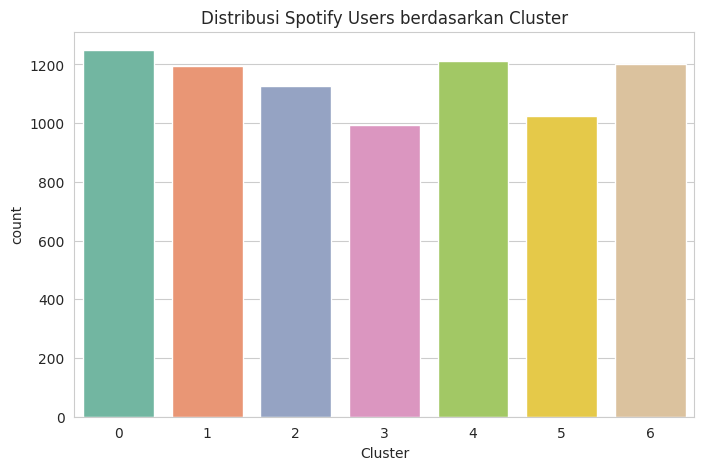

In [41]:
plt.figure(figsize=(8,5))
sns.countplot(x='Cluster', data=df_cluster, palette='Set2') # Use df_clusters
plt.title('Distribusi Spotify Users berdasarkan Cluster')
plt.show()

Pengguna Spotify tersebar relatif merata di seluruh klaster, dengan Cluster 0 memiliki jumlah terbanyak (pengguna aktif dan loyal), sementara Cluster 3 adalah yang terkecil — mayoritas pengguna Free yang perlu difokuskan untuk promosi upgrade ke Premium.

| **Cluster** | **Nama Segmen**                   | **Tipe Langganan Dominan** | **Gender Dominan** | **Tingkat Churn (%)** | **Karakteristik & Insight Utama**                                                                                |
| ----------- | --------------------------------- | -------------------------- | ------------------ | --------------------- | ---------------------------------------------------------------------------------------------------------------- |
| **0**       | 💐 **Selective Premium Listener** | Premium (35%)              | Female (36%)       | 28.1%                 | Pengguna premium yang sering skip, banyak dengar offline. Lebih picky terhadap lagu, perlu personalisasi konten. |
| **1**       | 💎 **Loyal Premium User**         | Premium (34.6%)            | Male (34%)         | 25.5%                 | Pengguna premium stabil, jarang skip, aktif tiap hari. Potensial jadi pelanggan jangka panjang.                  |
| **2**       | 🔥 **Premium Power Listener**     | Premium (36.8%)            | Male (35%)         | 25.9%                 | Pengguna premium paling loyal dan bernilai tinggi. Cocok untuk program loyalti & konten eksklusif.               |
| **3**       | 🆓 **Free Casual Listener**       | Free (100%)                | Other (35.6%)      | 24.2%                 | Pengguna gratis dengan engagement rendah. Target potensial untuk konversi ke Premium.                            |
| **4**       | 🎓 **Student Active Streamer**    | Student (35.8%)            | Other (34.7%)      | 26.6%                 | Pengguna muda yang sering online listening, aktif tapi sensitif terhadap harga. Cocok untuk promo student plan.  |
| **5**       | 📱 **Ad-Heavy Mobile User**       | Free (100%)                | Male (35.2%)       | 25.6%                 | Pengguna gratis di perangkat mobile, banyak iklan & aktivitas rendah. Perlu dorongan engagement.                 |
| **6**       | 🧠 **Loyal Premium Enthusiast**   | Premium (37.7%)            | Male (35.2%)       | 24.9%                 | Premium user paling aktif dan setia. Cocok jadi brand advocate dan early adopter fitur baru.                     |


| **Kategori**                       | **Cluster** | **Ciri Umum**                            | **Strategi Rekomendasi**                                                            |
| ---------------------------------- | ----------- | ---------------------------------------- | ----------------------------------------------------------------------------------- |
| 💎 **Premium Loyalist**            | 1, 2, 6     | Pengguna Premium aktif & loyal           | Fokus pada retensi dan eksklusivitas (rewards, playlist khusus, akses awal fitur).  |
| 🧠 **Selective & Student Segment** | 0, 4        | Campuran Premium/Student, sensitif harga | Dorong engagement lewat rekomendasi personal & promo edukatif.                      |
| 🆓 **Free Users**                  | 3, 5        | Pengguna gratis, engagement rendah       | Target konversi ke Premium dengan penawaran trial, bebas iklan, dan konten curated. |
